# One Plane 2D model
- The following notebook contains the solution for optimal control for the one plane problem in 2D
- The solver is in the package "Model_2D_Package"
- First is the solution from the bolza definition
- Then the solution from the min -w, where w<=h(t) for all t
- Last is a function for reconstructing a more detail trajectory when solving for low u values

In [46]:
%reset -f

import matplotlib.pyplot as plt
from casadi import *

import importlib
import Model_2D_Package.One_Plane_2D_solvers as model
importlib.reload(model)


<module 'Model_2D_Package.One_Plane_2D_solvers' from 'C:\\Users\\irmas\\Documents\\TUM\\CaseCourse\\CasADi\\Main\\Model_2D\\Model_2D_Package\\One_Plane_2D_solvers.py'>

# Plot wind

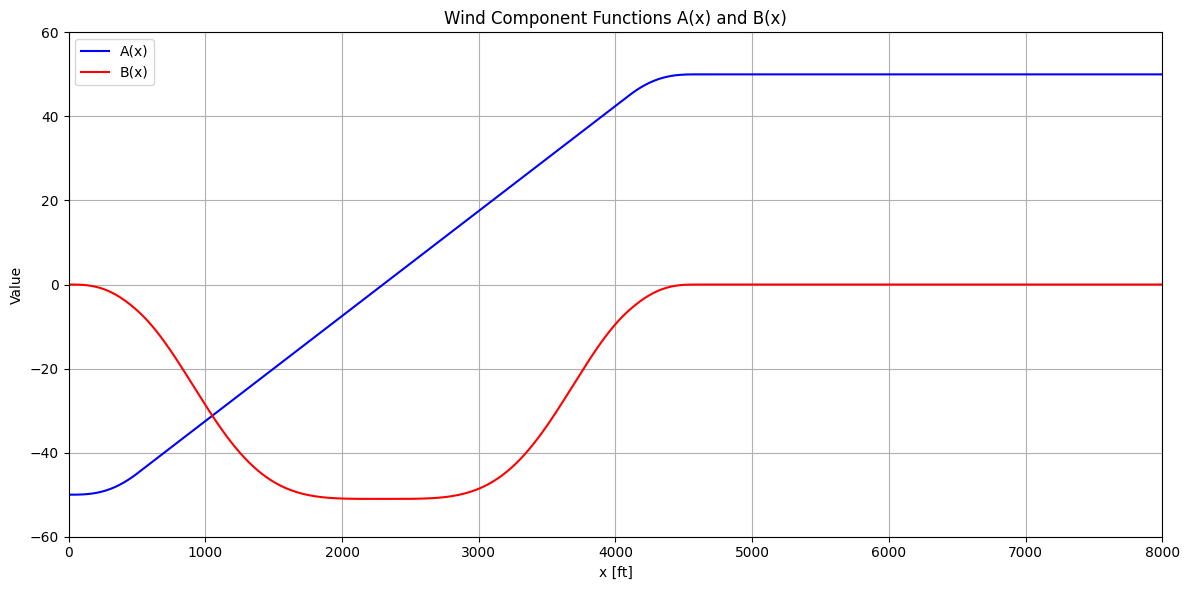

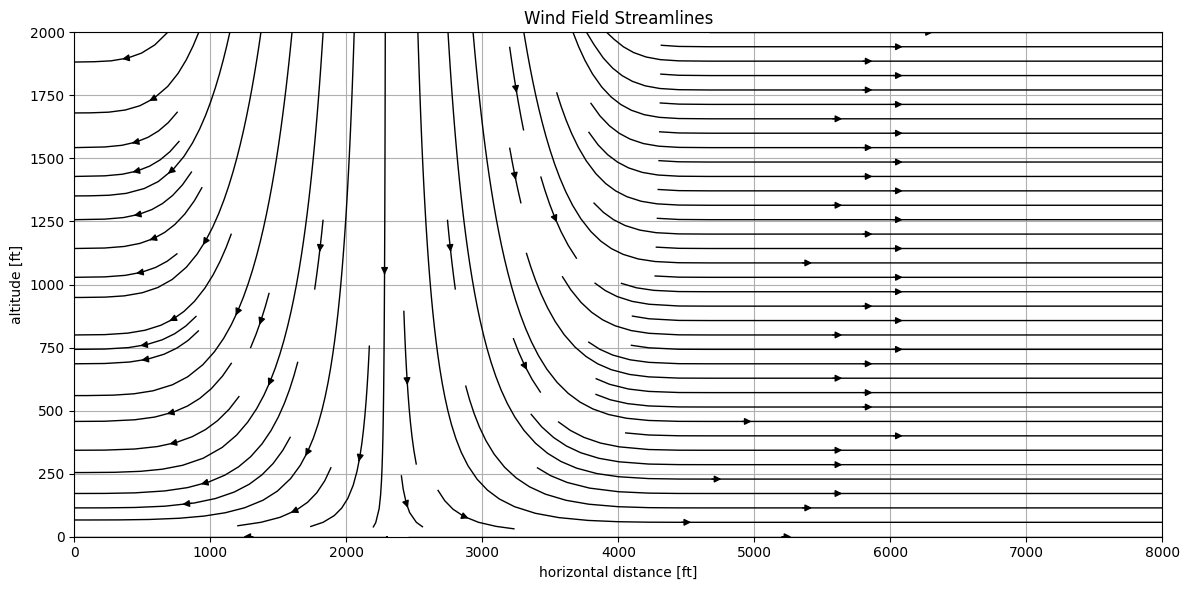

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Constants from table
a = 6e-8
b = -4e-11
c = -np.log(25 / 30.6) * 1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
k = 1

# Wind component functions
def A_func(x):
    if x <= 500:
        return -50 + a * x**3 + b * x**4
    elif x <= 4100:
        return 0.025 * (x - 2300)
    elif x <= 4600:
        return 50 - a * (4600 - x)**3 - b * (4600 - x)**4
    else:
        return 50

def B_func(x):
    if x <= 500:
        return d * x**3 + e * x**4
    elif x <= 4100:
        return -51 * np.exp(-c * (x - 2300)**4)
    elif x <= 4600:
        return d * (4600 - x)**3 + e * (4600 - x)**4
    else:
        return 0

# Vectorize functions
A_vec = np.vectorize(A_func)
B_vec = np.vectorize(B_func)

# 1. Plot A(x) and B(x)
x_vals = np.linspace(0, 8000, 500)
plt.figure(figsize=(12, 6))
plt.xlim([0, 8000])
plt.ylim([-60, 60])
plt.plot(x_vals, A_vec(x_vals), label='A(x)', color='blue')
plt.plot(x_vals, B_vec(x_vals), label='B(x)', color='red')
plt.title('Wind Component Functions A(x) and B(x)')
plt.xlabel('x [ft]')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Wind field plot using streamplot (to look like dotted flow lines)
x_grid = np.linspace(0, 8000, 200)
h_grid = np.linspace(0, 2000, 100)
X, H = np.meshgrid(x_grid, h_grid)

U = k * A_vec(X)
V = k * H * B_vec(X) / h_star

plt.figure(figsize=(12, 6))
plt.streamplot(
    X, H, U, V,
    color='black', linewidth=1, density=1.2, arrowsize=1
)
plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title('Wind Field Streamlines')
plt.xlim([0, 8000])
plt.ylim([0, 2000])
plt.grid(True)
plt.tight_layout()
plt.show()



## Bolza model

In [47]:
importlib.reload(model)
w_opt,J_opt = model.solve_ocp_one_plane_bolza(k_value=1)

# plot
print(J_opt)
model.plot_one_plane_2D(w_opt, True)


Total number of variables............................:      480
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0

Exception of type: IpoptException in file "Unknown File" at line -1:
 Exception message: Unknown Exception caught in Ipopt
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.45 s (  2.07ms)   1.54 s (  2.20ms)       700
       nlp_g  |   2.55 s (  3.63ms)   2.43 s (  3.47ms)       701
  nlp_grad_f  |   3.49 s (  6.34ms)   3.66 s (  6.65ms)       551
  nlp_hess_l  |  52.07 s ( 83.45ms) 

CasADi - 2025-06-08 02:38:30 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:95]


SystemError: <built-in function Function_call> returned a result with an exception set

Total number of variables............................:      480
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   1.8045270929568491e+04    1.5317721316851399e+12
Dual infeasibility......:   1.2050804798491299e-11    1.0229321037491309e-03
Constraint violation....:   1.8189894035458565e-12    1.8189894035458565e-12
Variable bound violation:   9.9999999947364415e-09    9.9999999947364415e-09
Complementari

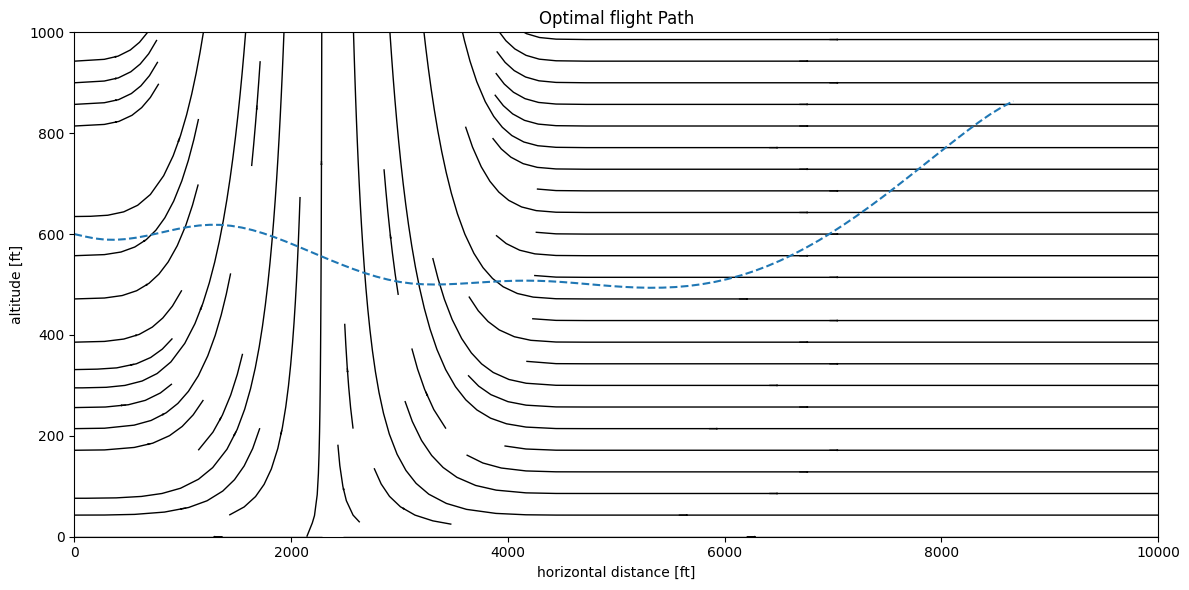

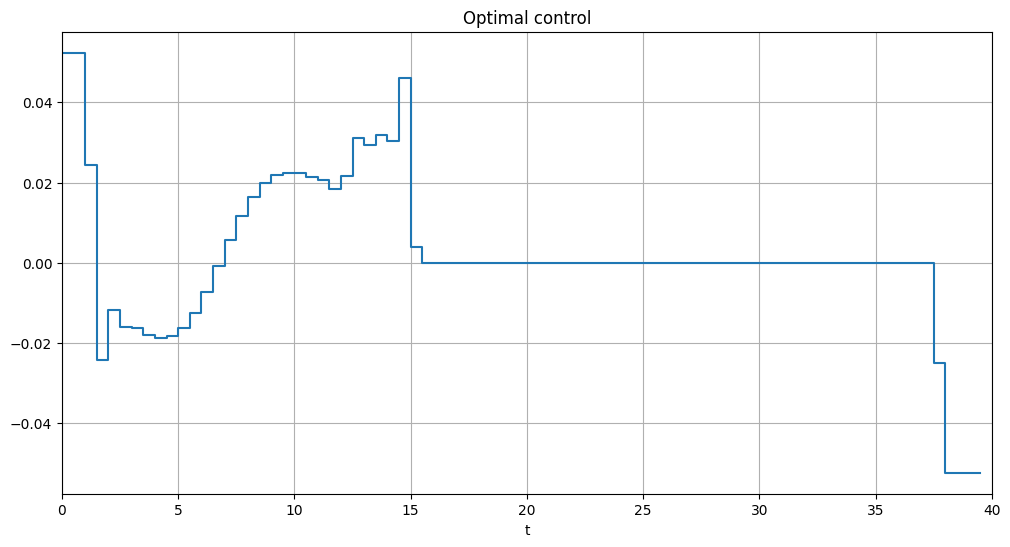

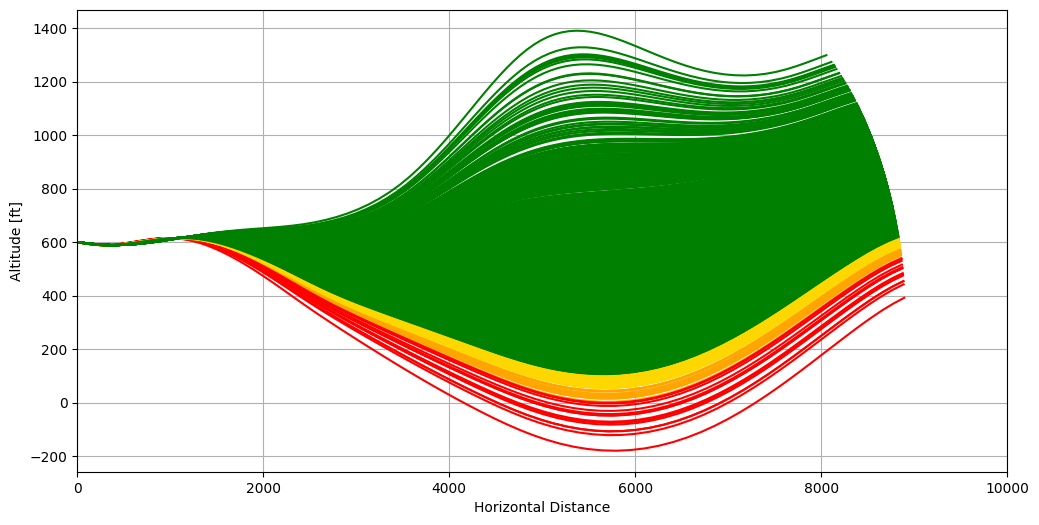

In [15]:

M = 1000
k_samples = np.random.normal(loc=1.0, scale=0.25, size=M)
min_hs = []
plt.figure(figsize=(12, 6))
for i in range(M):
    X, U, J, T = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt, True),k_samples[i],1)
    x1_opt = X[0::5]  # start at index 0, get every 6th:
    x2_opt = X[1::5]
    min_h=(min(x2_opt))
    min_hs.append(min_h)
    color = 'red' if min_h <= 0 else 'orange' if min_h <= 50 else 'gold' if min_h <= 100 else 'green'
    plt.plot(x1_opt, x2_opt, color=color)
    
plt.xlabel('Horizontal Distance')
plt.ylabel('Altitude [ft]')
plt.grid(True)
plt.xlim([0, 10000])
plt.show()


## min -w Model

Total number of variables............................:      481
                     variables with only lower bounds:       81
                variables with lower and upper bounds:       80
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:      160
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:  -5.0924153728914320e+02   -5.0924153728914320e+02
Dual infeasibility......:   5.0888810190455741e-10    5.0888810190455741e-10
Constraint violation....:   1.0400909639420001e-11    1.2505552149377763e-11
Variable bound violation:   9.9580854118208606e-09    9.9580854118208606e-09
Complementari

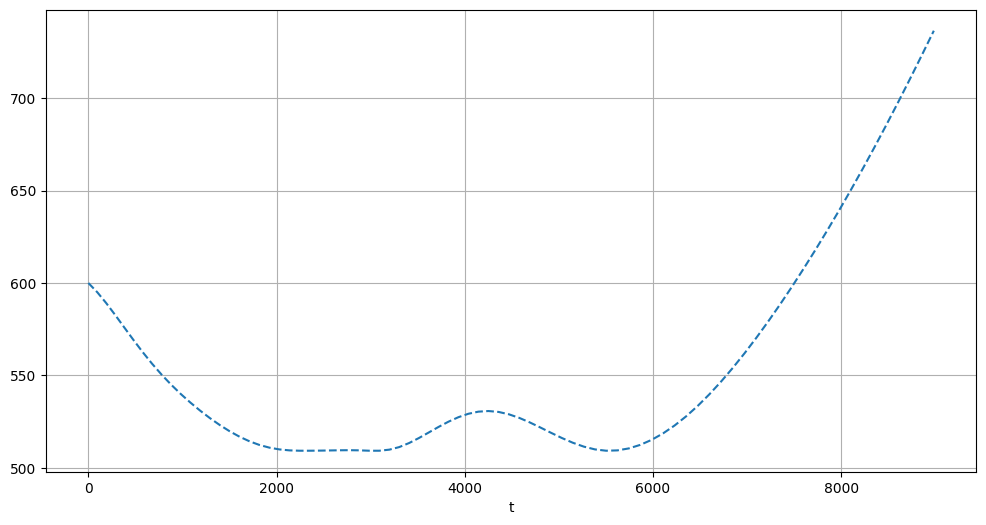

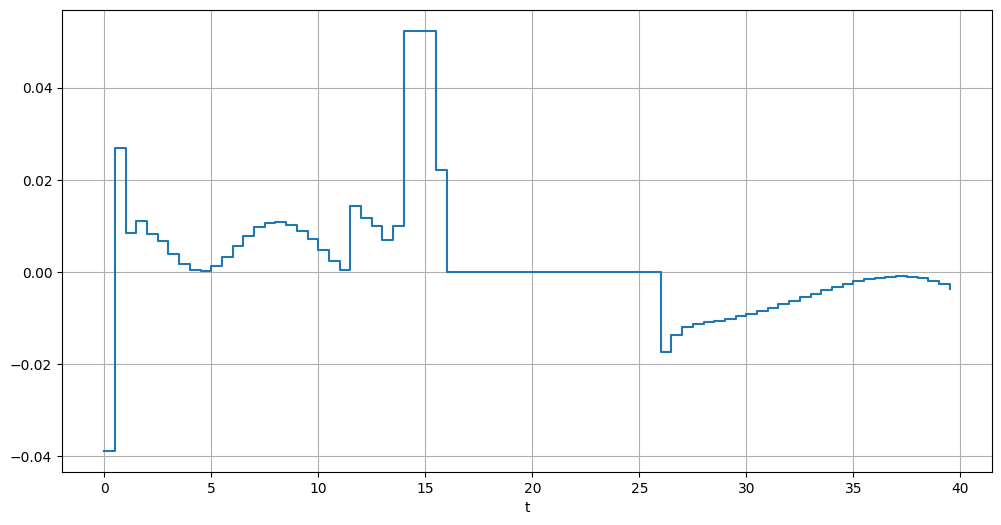

0

In [48]:

w_opt,J_opt = model.solve_ocp_one_plane_min_h(k_value=1)
print(-J_opt)
model.plot_one_plane_2D(w_opt,False)

Total number of variables............................:      481
                     variables with only lower bounds:       81
                variables with lower and upper bounds:       80
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:      160
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:  -5.0924153728914320e+02   -5.0924153728914320e+02
Dual infeasibility......:   5.0888810190455741e-10    5.0888810190455741e-10
Constraint violation....:   1.0400909639420001e-11    1.2505552149377763e-11
Variable bound violation:   9.9580854118208606e-09    9.9580854118208606e-09
Complementari

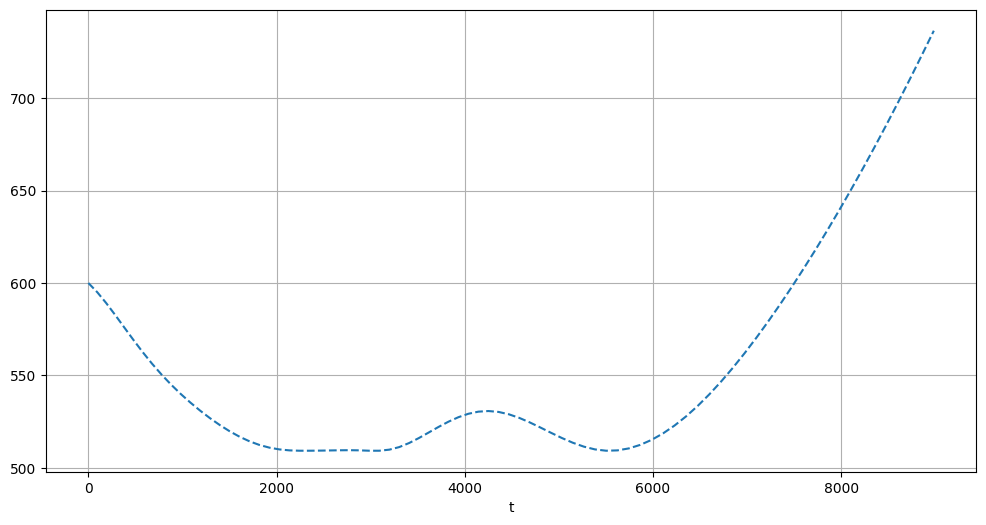

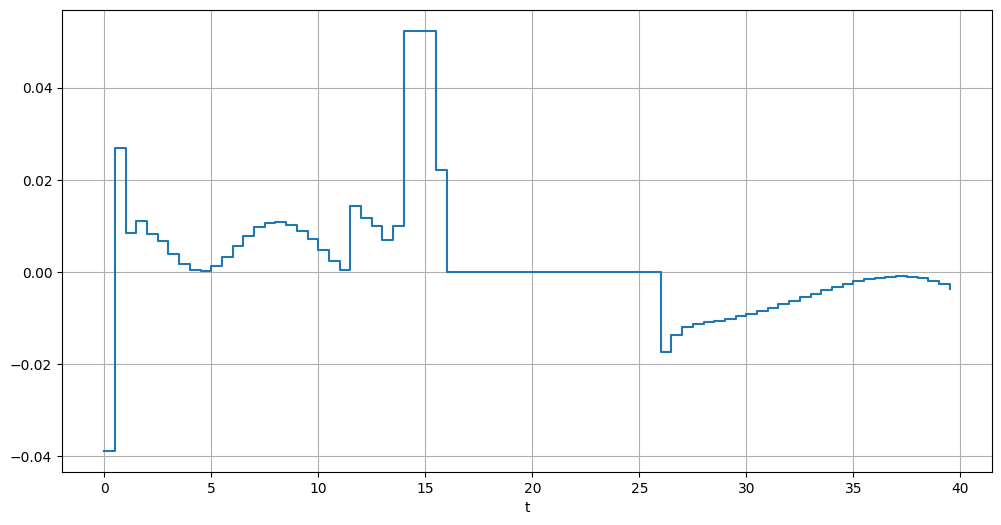

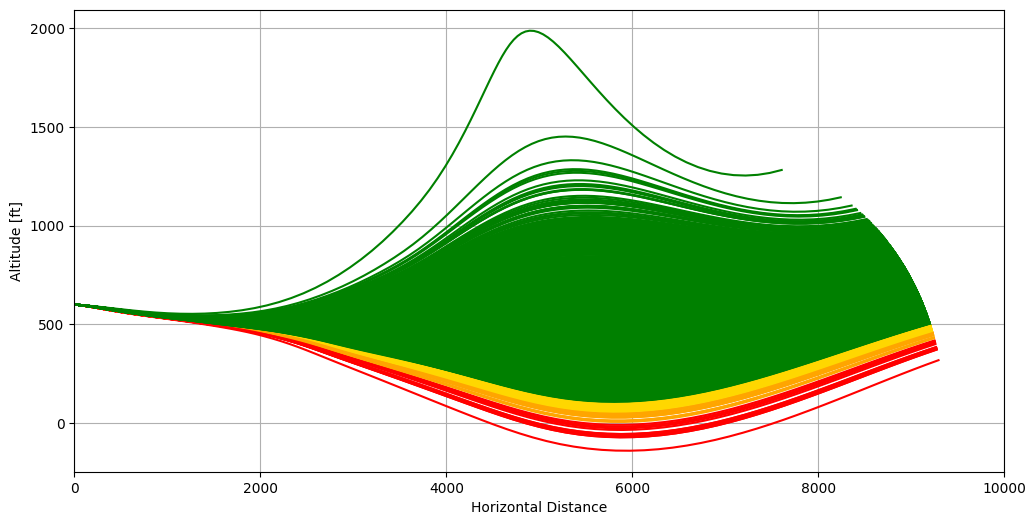

In [36]:


M = 1000
k_samples = np.random.normal(loc=1.0, scale=0.25, size=M)
min_hs = []
plt.figure(figsize=(12, 6))
for i in range(M):
    X, U, J, T = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt, False),k_samples[i],1)
    x1_opt = X[0::5]  # start at index 0, get every 6th:
    x2_opt = X[1::5]
    min_h=(min(x2_opt))
    min_hs.append(min_h)
    color = 'red' if min_h <= 0 else 'orange' if min_h <= 50 else 'gold' if min_h <= 100 else 'green'
    plt.plot(x1_opt, x2_opt, color=color)
    
plt.xlabel('Horizontal Distance')
plt.ylabel('Altitude [ft]')
plt.grid(True)
plt.xlim([0, 10000])
plt.show()

## Reconstruction function

Optimal cost J* = 3.87154e+17
509.24153728380156


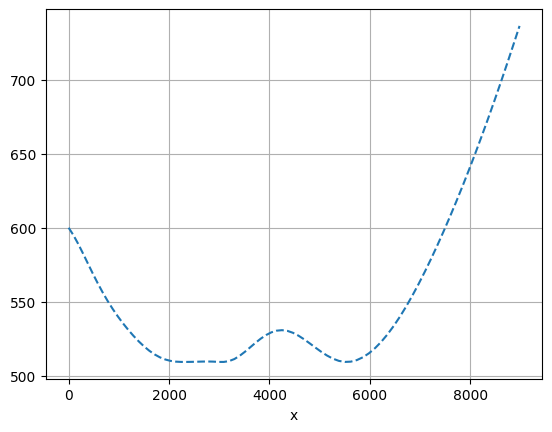

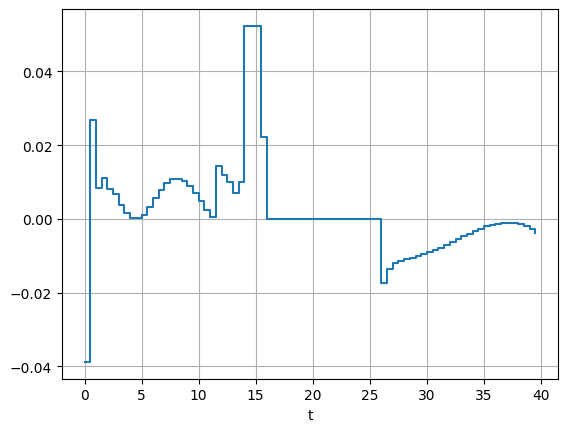

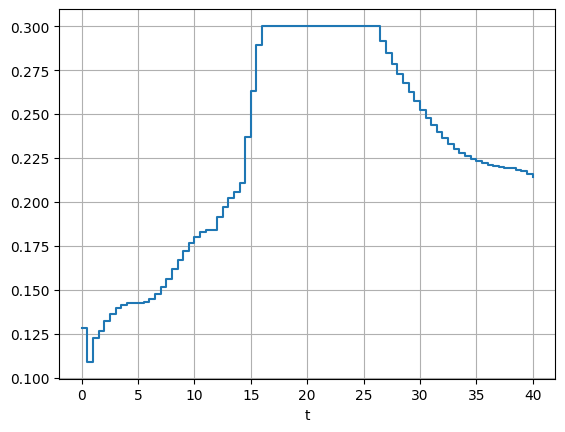

In [35]:

# Plot
X,U,J,T = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt, False), k_value=1, multipler=1)


x1_opt = X[0::5]    # start at index 0, get every 6th:
x2_opt = X[1::5]   
x3_opt = X[2::5]  
x4_opt = X[3::5] 
x5_opt = X[4::5]


print("Optimal cost J* =", J)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('x')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(T[:-1], U, where='post')
plt.xlabel('t')
plt.grid()
plt.show()  

plt.figure(2)
plt.clf()
plt.step(T, x5_opt, where='post')
plt.xlabel('t')
plt.grid()
plt.show() 

